## Goal: create a basic fair value model based off of the factors described in "Virtual Barrels" to help better understand the dynamics of crude

Factors:
(1) USD-CAD exchange rate. As US imports crude heavily from Canada, apparently this should show some merit.
(2) CPI Swap rate. Again, apparently crude (refined products like gasoline, and pass through via diesel, freight, trucking) is the main marginal cost in CPI goods basket, and as such, change and motion of CPI rate should be related to crude price.
(3) XOP, or some representative of stock market firms or firm which is heavily reliant on crude oil. XOM, HESS, FANG, any of these could be used, or this ETF price. 

In [2]:
# import statements
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

Y-Var: Load the crude price (WTI PRICE!)

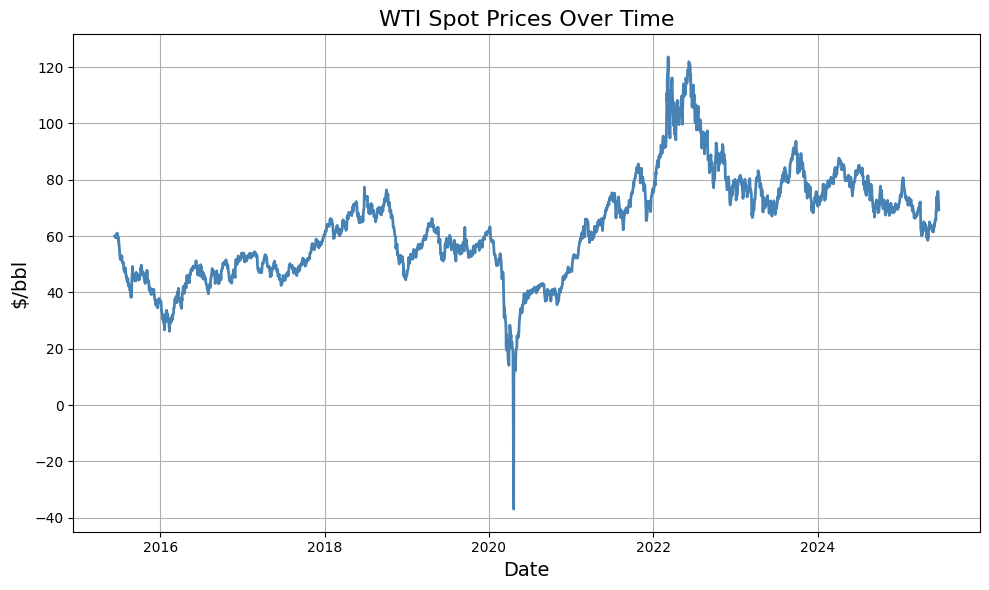

In [3]:
# WTI 'SPOT' (M1 Futures) prices from 2015

# Load CSV file
df = pd.read_csv('wtiHistoricalPrice.csv')

# print(df.head())

df['date'] = pd.to_datetime(df['date'], errors='coerce')
wtiPriceDF = df.dropna(subset=['date', 'wti_price'])  # Drop bad rows

plt.figure(figsize=(10, 6))
plt.plot(wtiPriceDF['date'], wtiPriceDF['wti_price'], color='steelblue', linewidth=2)
plt.title('WTI Spot Prices Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('$/bbl', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

X-Var: Load USD-CAD Historical Exchange rate

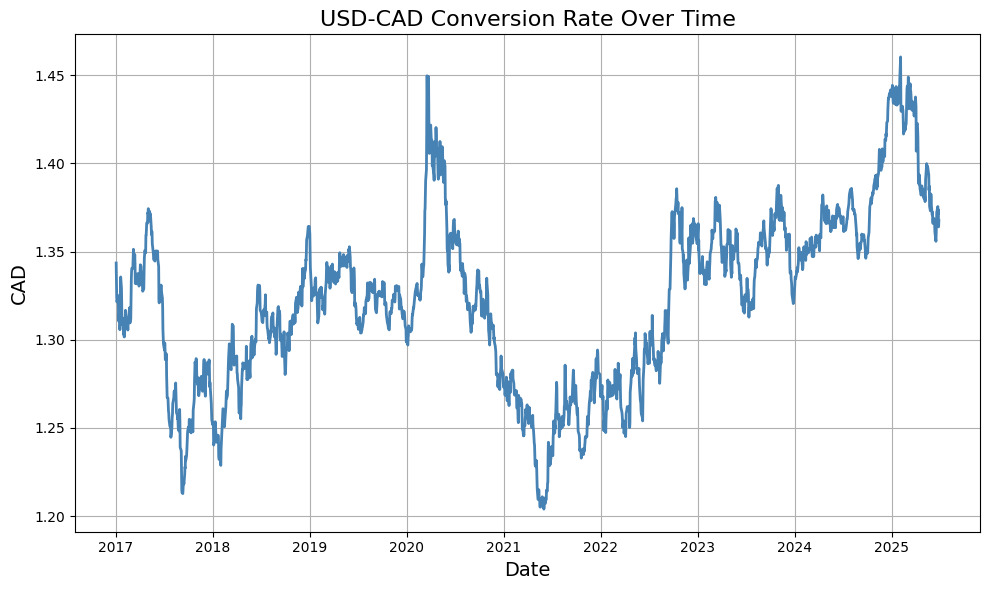

In [4]:
# ChatGPT: By 2005, Canada overtook other suppliers and has remained the largest single source of U.S. crude imports ever since.
# However, it looks like my data goes back to 2017 Jan 3, so..... ig thats where we start

# Load CSV file
df = pd.read_csv('FX_RATES_DAILY-sd-2017-01-03.csv', skiprows=39)

df['date'] = pd.to_datetime(df['date'], errors='coerce')
usdCadDF = df.dropna(subset=['date', 'FXUSDCAD'])  # Drop bad rows

plt.figure(figsize=(10, 6))
plt.plot(usdCadDF['date'], usdCadDF['FXUSDCAD'], color='steelblue', linewidth=2)
plt.title('USD-CAD Conversion Rate Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('CAD', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Load Relevant stocks to crude oil (FANG, XOP, COP???)

<>:12: SyntaxWarning: invalid escape sequence '\$'
<>:12: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_29377/1147165419.py:12: SyntaxWarning: invalid escape sequence '\$'
  fangPriceDF['Open'] = fangPriceDF['Open'].str.replace('[\$,]', '', regex=True)


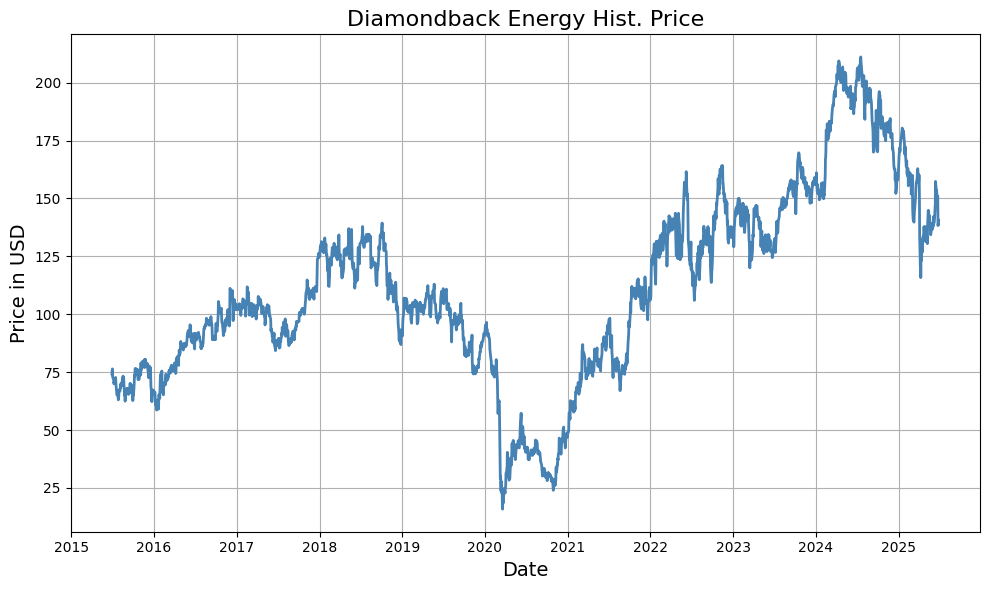

In [5]:
# FANG - Diamondback Energy (Diamondback Energy is a U.S. shale oil and gas producer focused on the Permian Basin, known for efficient operations, high oil leverage, and strong sensitivity to crude price movements.)

# Load CSV file
df = pd.read_csv('fangHistoricalQuotes.csv')

# print(df.head())

# fangPriceDF = df[['Date', 'Open']]
fangPriceDF = df.dropna(subset=['Date', 'Open'])  # Drop bad rows
fangPriceDF['Date'] = pd.to_datetime(fangPriceDF['Date'])
# print(fangPriceDF['Open'].head(10))
fangPriceDF['Open'] = fangPriceDF['Open'].str.replace('[\$,]', '', regex=True)
fangPriceDF['Open'] = pd.to_numeric(fangPriceDF['Open'], errors='coerce')
# fangPriceDF = fangPriceDF.dropna()  # Drop bad rows

# print(fangPriceDF['Open'])

plt.figure(figsize=(10, 6))
plt.plot(fangPriceDF['Date'], fangPriceDF['Open'], color='steelblue', linewidth=2)
plt.title('Diamondback Energy Hist. Price', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price in USD', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

# i feel so dumb, took me so long to realize that the dollar signs were cooking errythng

Bring in INFLATION data...

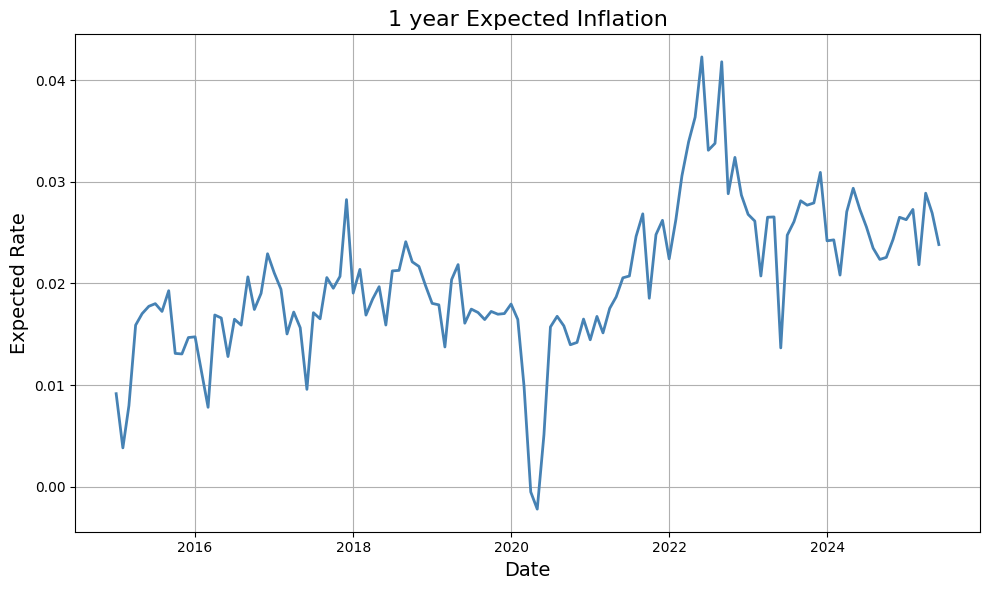

In [6]:
# I use the dataset’s 1-year expected inflation column, capturing annual inflation forecasts from 1982 onward, derived from a comprehensive inflation expectations model output.

# Load CSV file
df = pd.read_csv('expectedCpiMonthly.csv')
df.rename(columns={'Model Output Date': 'DATE', ' 1 year Expected Inflation': 'INFLATION'}, inplace=True)

# print(df.head())

cpiDF = df.dropna(subset=['DATE', 'INFLATION'])  # Drop bad rows
cpiDF['DATE'] = pd.to_datetime(cpiDF['DATE'])
cpiDF['INFLATION'] = pd.to_numeric(cpiDF['INFLATION'], errors='coerce')

# print(cpiDF['INFLATION'])

plt.figure(figsize=(10, 6))
plt.plot(cpiDF['DATE'], cpiDF['INFLATION'], color='steelblue', linewidth=2)
plt.title('1 year Expected Inflation', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Expected Rate', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Join all factors into one 'big, beautiful DF'

In [7]:
def interpolate_to_daily(df, date_col, value_col):
    """
    Given a dataframe with date and value columns, interpolate values to a daily frequency.
    Returns a new DataFrame indexed by daily dates with interpolated values.
    """
    df = df[[date_col, value_col]].dropna()
    df = df.sort_values(date_col).set_index(date_col)
    # Reindex to daily frequency
    daily_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df_daily = df.reindex(daily_idx)
    # Interpolate missing values linearly
    df_daily[value_col] = df_daily[value_col].interpolate(method='linear')
    df_daily = df_daily.rename_axis(date_col).reset_index()
    return df_daily

# Interpolate each dataset to daily frequency
wti_daily = interpolate_to_daily(wtiPriceDF, 'date', 'wti_price')
usd_cad_daily = interpolate_to_daily(usdCadDF, 'date', 'FXUSDCAD')
fang_daily = interpolate_to_daily(fangPriceDF, 'Date', 'Open')
cpi_daily = interpolate_to_daily(cpiDF, 'DATE', 'INFLATION')

# Rename date columns to a common name for merging
wti_daily = wti_daily.rename(columns={'date': 'Date'})
usd_cad_daily = usd_cad_daily.rename(columns={'date': 'Date'})
fang_daily = fang_daily.rename(columns={'Date': 'Date'})
cpi_daily = cpi_daily.rename(columns={'DATE': 'Date'})

# Merge all on Date
merged_df = wti_daily.merge(usd_cad_daily, on='Date', how='inner') \
                     .merge(fang_daily, on='Date', how='inner') \
                     .merge(cpi_daily, on='Date', how='inner')

# Rename columns for clarity
merged_df.columns = ['Date', 'WTI_Price', 'USD_CAD', 'FANG_Price', 'Inflation_1yr_Exp']

# Optional: set Date as index
merged_df = merged_df.set_index('Date')

print(merged_df.head())

correlations = merged_df.corr()['WTI_Price'].drop('WTI_Price')
print("Correlations with WTI Price:")
print(correlations)


            WTI_Price   USD_CAD  FANG_Price  Inflation_1yr_Exp
Date                                                          
2017-01-03  52.360000  1.343500  102.500000           0.020924
2017-01-04  53.260000  1.331500  103.250000           0.020873
2017-01-05  53.770000  1.324400  103.930000           0.020821
2017-01-06  53.980000  1.321400  103.640000           0.020769
2017-01-07  53.303333  1.322267  103.396667           0.020718
Correlations with WTI Price:
USD_CAD             -0.098367
FANG_Price           0.705354
Inflation_1yr_Exp    0.885545
Name: WTI_Price, dtype: float64


Check model performance!

In [8]:
# Prepare X and y
X = merged_df[['USD_CAD', 'FANG_Price', 'Inflation_1yr_Exp']]
y = merged_df['WTI_Price']

# Add constant for intercept
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print summary output
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              WTI_Price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     5140.
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:35:43   Log-Likelihood:                -10429.
No. Observations:                3072   AIC:                         2.087e+04
Df Residuals:                    3068   BIC:                         2.089e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                98.8626      3.94